<a href="https://colab.research.google.com/github/harshita042/PRML-CSL2050/blob/main/lab3_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Linear Regression

Linear Regression is a fundamental algorithm in machine learning used to predict a continuous value (target) based on one or more input features.

In this lab, we will cover -


*   Simple Linear Regression: One input feature.
*   Multiple Linear Regression: Multiple input features.
*   Polynomial Regression: Modeling non-linear relationships.

### Import libraries and load dataset

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target  # The median house value in $100,000s

# Inspect the data
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [51]:
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

##  California Housing Dataset Summary

- **Number of examples:** 20,640  
- **Number of numerical attributes per example:** 8  
- **Target label:** Median house value  
- **Missing values:** None  


### Exploratory Data Analysis

Check the distritbution of features

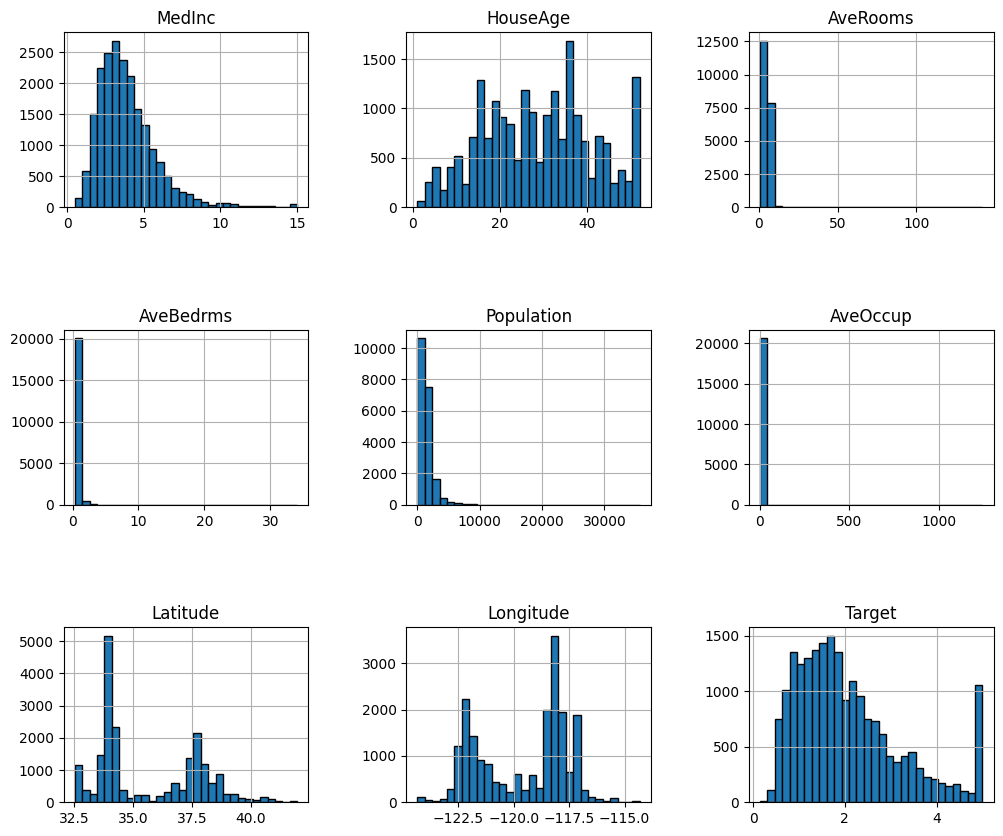

In [52]:
df.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

##  Histogram Analysis of California Housing Features

- **MedInc** has a long tail distribution — salary of people is more or less normally distributed with a few folks earning high salaries.

- **HouseAge** shows a more or less uniform distribution.

- The range for features like **AveRooms**, **AveBedrms**, **AveOccup**, and **Population** is large and contains a small number of large values (as seen from unnoticeable bins on the right side of the histograms). This suggests the presence of potential outliers in these features.

- **Latitude** and **Longitude** carry geographical information. Their combination helps determine the price of the house.

- **Target(Median House Value)** also has a long tail distribution and spikes toward the end. This is because houses priced above 5 are capped at a value of 5.


Let us look at some features of interest (they might have outliers)

In [53]:
features_of_interest = ["AveRooms", "AveBedrms", "AveOccup", "Population"]
df[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


##  Outlier Detection from Summary Statistics

We can observe that there is a large difference between the 75th percentile and the maximum values of **AveRooms**, **AveBedrms**, **Population**, and **AveOccup** — which confirms our intuition about the presence of outliers or extreme values in these features.


##  What Is a Correlation Map?

A correlation map shows how strongly each pair of variables in your dataset is related. The values range from -1 to +1

- **+1** → Perfect positive correlation (as one increases, the other increases)  
- **0** → No correlation  
- **–1** → Perfect negative correlation (as one increases, the other decreases)  

The heatmap uses color gradients to make these relationships visually intuitive:  
- **Red** for strong positive correlation  
- **Blue** for strong negative correlation  






MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Target        0
dtype: int64


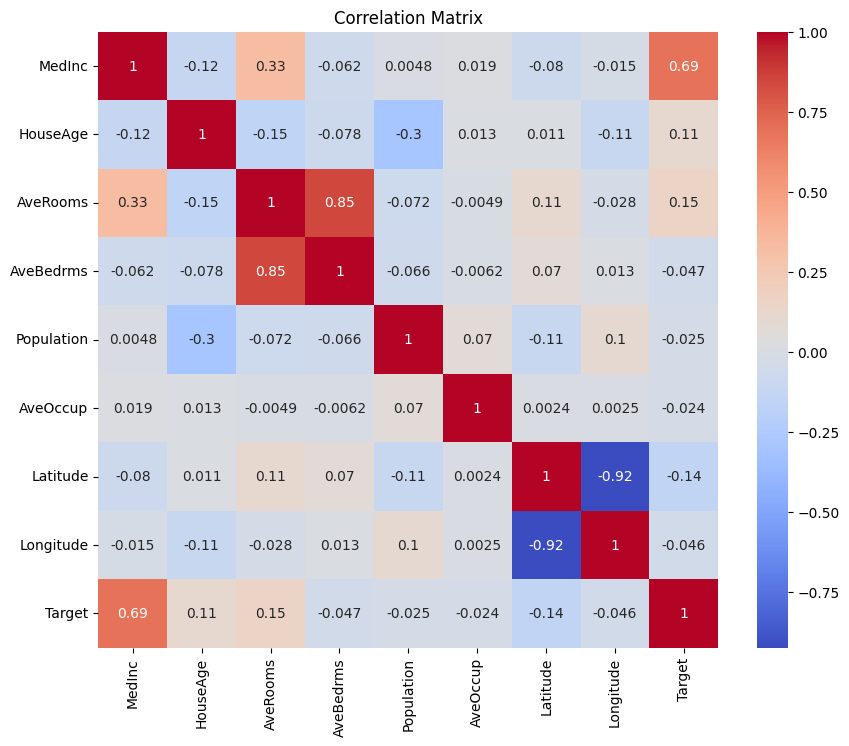

In [54]:
# Check for missing values
print(df.isnull().sum())

# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

**MedInc vs Target: 0.69** → Strong positive correlation.
Median income is a good predictor of house value.

**AveRooms vs AveBedrms: 0.85** → Very high correlation. These features may be redundant—consider dropping one or combining them.

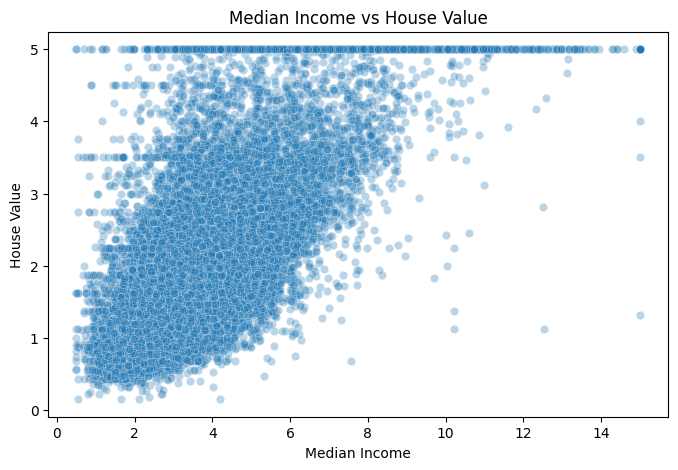

In [73]:
# Visualizing the relationship between Median Income and House Value
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['MedInc'], y=df['Target'], alpha=0.3)
plt.title("Median Income vs House Value")
plt.xlabel("Median Income")
plt.ylabel("House Value")
plt.show()

### Data Preprocessing

In [56]:
# Select Features (X) and Target (y)
# axis=1 means we are dropping a COLUMN (Target) from the dataframe
# axis=0 would mean dropping a ROW instead
X = df.drop('Target', axis=1)
y = df['Target']

# Split into Train and Test sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Standardization)
# We fit the scaler on training data and transform both train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training Data Mean:", X_train_scaled.mean())
print("Training Data Std:", X_train_scaled.std())


Training Data Mean: 1.7799069711650403e-16
Training Data Std: 1.0


### Simple Linear Regression

In [57]:
# Select only the 'MedInc' feature (Column index 0)
# X_train_scaled[:, 0] (: means select all rows and 0 refers to the column at zeroth index) gives a 1D array of shape (n_samples,)
# But scikit-learn models expect a 2D array of shape (n_samples, n_features)
# So we use reshape(-1, 1) to convert it into a proper column vector:
#   -1 → automatically infers the number of rows (samples)
#    1 → specifies one feature column
X_train_1feat = X_train_scaled[:, 0].reshape(-1, 1)
X_test_1feat = X_test_scaled[:, 0].reshape(-1, 1)
# Before reshape: (n_samples,) → looks like [x1, x2, x3, ...]
# After reshape:  (n_samples, 1) → looks like [[x1], [x2], [x3], ...]


In [58]:
# Train Model
simple_model = LinearRegression()
simple_model.fit(X_train_1feat, y_train)

LinearRegression()

In [59]:
# Predict
y_pred_simple = simple_model.predict(X_test_1feat)

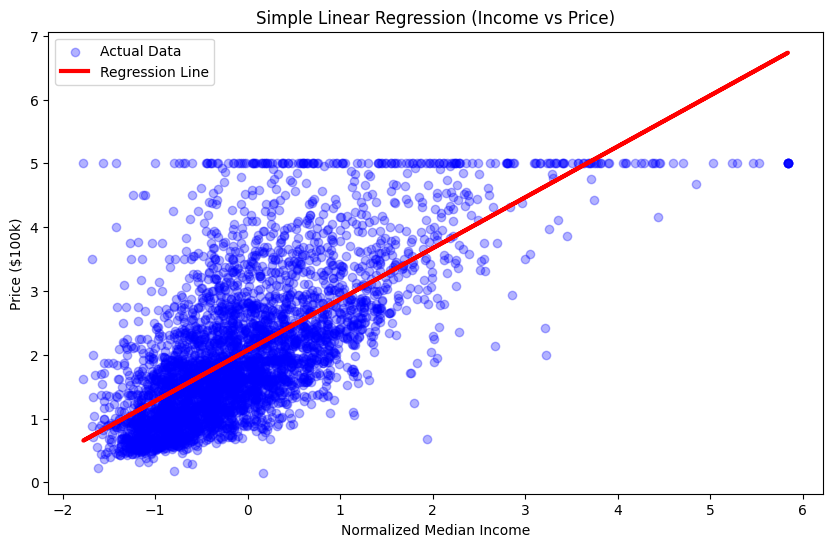

In [60]:
# VISUALIZATION (Regression Line)
plt.figure(figsize=(10, 6))
plt.scatter(X_test_1feat, y_test, color='blue', alpha=0.3, label='Actual Data')
plt.plot(X_test_1feat, y_pred_simple, color='red', linewidth=3, label='Regression Line')
plt.title('Simple Linear Regression (Income vs Price)')
plt.xlabel('Normalized Median Income')
plt.ylabel('Price ($100k)')
plt.legend()
plt.show()

In [61]:
# Evaluate
print("--- Simple Linear Regression Results ---")
r2_simple = r2_score(y_test, y_pred_simple)
mse_simple = mean_squared_error(y_test, y_pred_simple)
print(f"MSE: {mse_simple:.4f}")
print(f"Simple Linear Regression R2 Score: {r2_simple:.4f}")

--- Simple Linear Regression Results ---
MSE: 0.7091
Simple Linear Regression R2 Score: 0.4589


r square ==> yi is the actual value and yi hat is predicted value
more the r square the better


### Multiple Linear Regression

In [62]:
# Train Model (on all scaled features)
multi_model = LinearRegression()
multi_model.fit(X_train_scaled, y_train)

LinearRegression()

In [63]:
# Predict
y_pred_multi = multi_model.predict(X_test_scaled)

In [64]:
# Evaluate
r2_multi = r2_score(y_test, y_pred_multi)
mse_multi = mean_squared_error(y_test, y_pred_multi)

In [65]:
print("--- Multiple Linear Regression Results ---")
print(f"MSE: {mse_multi:.4f}")
print(f"R2 Score: {r2_multi:.4f}")
print(f"R2 Improvement over Simple Regression: {r2_multi - r2_simple:.4f}")

--- Multiple Linear Regression Results ---
MSE: 0.5559
R2 Score: 0.5758
R2 Improvement over Simple Regression: 0.1169


### Polynomial Regression

Linear models assume a straight line. Let us try to instead fit a curve.

model is still liinear regression but it adds polynomial features.

#### Simple Polynomial Regression

In [66]:
# Create Polynomial Features (Degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_1feat) # Using MedInc only
X_test_poly = poly.transform(X_test_1feat)

In [67]:
# Train
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

LinearRegression()

In [68]:
y_pred_poly = poly_model.predict(X_test_poly)

# Evaluate (MSE and R2)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print("--- Simple Polynomial Regression (Degree 2) Results ---")
print(f"MSE: {mse_poly:.4f}")
print(f"R2 Score: {r2_poly:.4f}")

--- Simple Polynomial Regression (Degree 2) Results ---
MSE: 0.7033
R2 Score: 0.4633


In [69]:
# Visualize
# Create a smooth range for plotting
X_range = np.linspace(X_test_1feat.min(), X_test_1feat.max(), 100).reshape(-1, 1)
y_range_pred = poly_model.predict(poly.transform(X_range))

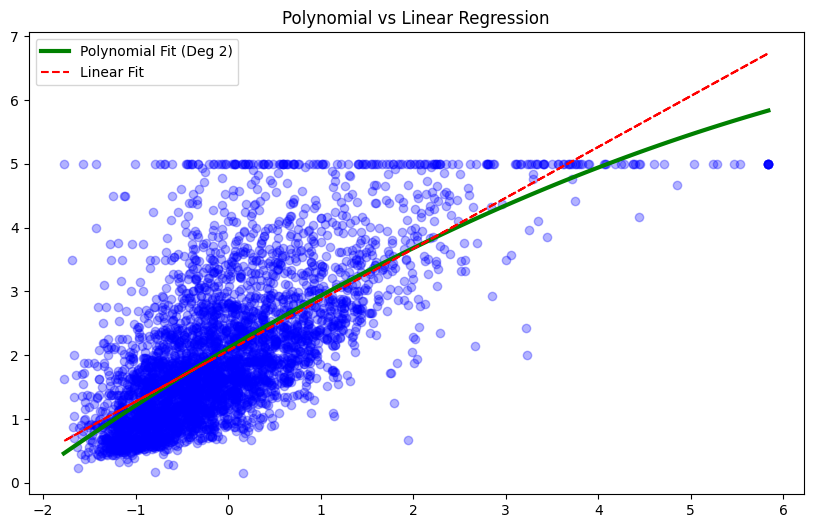

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test_1feat, y_test, color='blue', alpha=0.3)
plt.plot(X_range, y_range_pred, color='green', linewidth=3, label='Polynomial Fit (Deg 2)')
plt.plot(X_test_1feat, y_pred_simple, color='red', linestyle='--', label='Linear Fit')
plt.title('Polynomial vs Linear Regression')
plt.legend()
plt.show()

#### Polynomial Regression with all features

In [71]:
# Polynomial Regression with ALL features (Degree = 2)
poly_all = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly_all = poly_all.fit_transform(X_train_scaled)
X_test_poly_all = poly_all.transform(X_test_scaled)

print("Original feature count:", X_train_scaled.shape[1])
print("Polynomial feature count:", X_train_poly_all.shape[1])

Original feature count: 8
Polynomial feature count: 44


In [72]:
poly_all_model = LinearRegression()
poly_all_model.fit(X_train_poly_all, y_train)

y_pred_poly_all = poly_all_model.predict(X_test_poly_all)

r2_poly_all = r2_score(y_test, y_pred_poly_all)
mse_poly_all = mean_squared_error(y_test, y_pred_poly_all)

print("--- Polynomial Regression (All Features) ---")
print(f"MSE: {mse_poly_all:.4f}")
print(f"R2 Score: {r2_poly_all:.4f}")

--- Polynomial Regression (All Features) ---
MSE: 0.4643
R2 Score: 0.6457


## In-lab exercises

Exercise 1: Feature Engineering

Create a new feature Rooms_per_Person = AveRooms / AveOccup. Retrain the Multiple Linear Regression model with this new feature and check if the MSE and R2 score improve.

Exercise 2: Outlier Detection and Removal

Remove outliers from AveRooms, AveBedrms, AveOccup, and Population using the IQR Method. Then retrain the model. Perform Multiple Linear Regression and report the MSE and R2 scores.

Exercise 3: Finding the Best Polynomial Degree

Find the best degree for simple polynomial regression (1 feature) and multiple polynomial regression

Exercise 4: Location + Income Model

We suspect that Location (Latitude, Longitude) and Income (MedInc) are the most important factors.

Train a Multiple Linear Regression using ONLY these 3 features.

Train a Polynomial Regression (Degree 2 and the previously found best degree) using ONLY these 3 features. Compare the results.
